# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [394]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from os import system
system("pip install graphviz")
system("pip install imblearn")
system("pip install xgboost")
system("pip install seaborn")
system("pip install shap")
import shap
import seaborn as sns
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from collections import Counter
import re
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### 데이터 셋 읽어오기

In [395]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [396]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

In [397]:
# 변수 유형별 분석을 위한 리스트 분할
num_col = ['bant_submit', 'com_reg_ver_win_rate', 'customer_idx', 'historical_existing_cnt',
           'it_strategic_ver', 'idit_strategic_ver', 'id_strategic_ver', 'lead_desc_length',
           'ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu', 'lead_owner']
cat_col = ['customer_country', 'business_unit', 'customer_type', 'enterprise',
           'customer_job', 'inquiry_type', 'product_category', 'product_subcategory', 'product_modelname',
           'customer_country.1', 'customer_position', 'response_corporate', 'expected_timeline',
           'business_area', 'business_subarea']
test_col = []

In [398]:
col_list = []
col_list.extend(num_col)
col_list.extend(cat_col)
col_list.extend(['is_converted'])

test_col.extend(num_col)
test_col.extend(cat_col)
test_col.extend(['is_converted', 'id'])

df_train = df_train[col_list]
df_test = df_test[test_col]

In [399]:
from tqdm import tqdm

# 텍스트 데이터 소문자로 통일
for col_name in tqdm(cat_col):
    # 임시로 결측치 ''로 채우기
    df_train[col_name] = df_train[col_name].fillna('')
    df_test[col_name] = df_test[col_name].fillna('')

    df_train[col_name] =  df_train[col_name].apply(lambda x: x.lower())
    df_test[col_name] = df_test[col_name].apply(lambda x: x.lower())

    # 다시 되돌리기
    df_train.loc[df_train[col_name] == '', col_name] = np.nan
    df_test.loc[df_test[col_name] == '', col_name] = np.nan

100%|██████████| 15/15 [00:00<00:00, 31.78it/s]


In [400]:
# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

55164


False    50573
True      4591
Name: is_converted, dtype: int64

## 수치형 변수 전처리

#### (1) it_strategic_ver/id_strategic_ver/idit_strategic_ver

In [401]:
df_train['it_strategic_ver'] = df_train['business_unit'].apply(lambda x: 1 if x == 'it' else 0)
df_train['id_strategic_ver'] = df_train['business_unit'].apply(lambda x: 1 if x == 'id' else 0)
df_train['idit_strategic_ver'] = (df_train['it_strategic_ver'] | df_train['id_strategic_ver']).astype(int)

df_test['it_strategic_ver'] = df_test['business_unit'].apply(lambda x: 1 if x == 'it' else 0)
df_test['id_strategic_ver'] = df_test['business_unit'].apply(lambda x: 1 if x == 'id' else 0)
df_test['idit_strategic_ver'] = (df_test['it_strategic_ver'] | df_test['id_strategic_ver']).astype(int)

#### (2) ver_win_rate_x/ver_win_ratio_per_bu

In [402]:
df_train['ver_win_rate_x'] = df_train['ver_win_rate_x'].fillna(0)
df_train['ver_win_ratio_per_bu'] = df_train['ver_win_ratio_per_bu'].fillna(0)

df_test['ver_win_rate_x'] = df_test['ver_win_rate_x'].fillna(0)
df_test['ver_win_ratio_per_bu'] = df_test['ver_win_ratio_per_bu'].fillna(0)

- 결측치 비율 0.3 이상인 값 제거

In [403]:
threshold = 0.3

# 각 행별 결측치 비율 계산
false_values = df_train['is_converted'] == False
missing_values = df_train.loc[false_values].isnull().mean(axis=1)

# 결측치 비율이 threshold보다 작은 행만 남깁니다.
df_train = df_train.drop(missing_values[missing_values >= threshold].index)

In [404]:
missing_values.value_counts()

0.275862    12114
0.241379    10628
0.310345     7730
0.206897     5484
0.172414     4960
0.103448     3143
0.137931     2952
0.344828     1526
0.068966      840
0.034483      803
0.379310      280
0.000000       78
0.448276       21
0.413793       14
dtype: int64

In [405]:
df_train['is_converted'].value_counts()

False    41002
True      4591
Name: is_converted, dtype: int64

#### (3) historical_existing_cnt 전처리

In [406]:
# 'customer_idx', 'lead_owner'가 같고 is_converted가 True인 경우를 count
df_his = pd.DataFrame(df_train[(df_train['historical_existing_cnt'].isnull()==True)&(df_train['is_converted']==True)]\
 [['customer_idx', 'lead_owner']].value_counts()).reset_index()
df_his = df_his[(df_his[0]>1)]
df_his['is_converted'] = True

# 'customer_idx', 'lead_owner'가 같고 is_converted가 True인 경우 df_his값으로 채우기
df = pd.merge(df_train, df_his, on=['customer_idx', 'lead_owner', 'is_converted'], how='left')
df_train['historical_existing_cnt'] = df_train['historical_existing_cnt'].fillna(df[0])

In [407]:
df_train['historical_existing_cnt'] = df_train.groupby('business_unit')['historical_existing_cnt'].transform(lambda x: x.fillna(x.mode().iloc[0]) \
                                                                                                             if x.isnull().any() and x.mode().size > 0 else x)

df_test['historical_existing_cnt'] = df_test.groupby('business_unit')['historical_existing_cnt'].transform(lambda x: x.fillna(x.mode().iloc[0]) \
                                                                                                           if x.isnull().any() and x.mode().size > 0 else x)

df_train['historical_existing_cnt'] = df_train['historical_existing_cnt'].fillna(method='ffill')
df_test['historical_existing_cnt'] = df_test['historical_existing_cnt'].fillna(method='ffill')

df_train = df_train[df_train['historical_existing_cnt'] <= 1000]

In [408]:
# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

45590


False    40999
True      4591
Name: is_converted, dtype: int64

#### (4) lead_owner별 가중치 컬럼 추가

In [409]:
historical_all = df_train.groupby(['lead_owner','is_converted']).size().reset_index(name='count')

# is_converted 값에 따라서 true_cnt와 false_cnt 계산
historical_all['true_cnt'] = historical_all['is_converted'].map({True: 1, False: 0}) * historical_all['count']
historical_all['false_cnt'] = historical_all['is_converted'].map({True: 0, False: 1}) * historical_all['count']

historical_all

,lead_owner,is_converted,count,true_cnt,false_cnt
0,0,False,318,0,318
1,0,True,20,20,0
2,1,False,4,0,4
3,1,True,15,15,0
4,2,False,27,0,27
...,...,...,...,...,...
1370,1105,False,1,0,1
1371,1106,False,1,0,1
1372,1110,False,1,0,1
1373,1111,False,1,0,1


In [410]:
# lead_owner별로 평균 계산
historical_summary = historical_all.groupby(['lead_owner']).agg({'count': 'sum', 'true_cnt': 'sum', 'false_cnt': 'sum'}).reset_index()
historical_summary['historical_true_mean'] = historical_summary['true_cnt'] / historical_summary['count']
historical_summary['historical_false_mean'] = historical_summary['false_cnt'] / historical_summary['count']
historical_summary

,lead_owner,count,true_cnt,false_cnt,historical_true_mean,historical_false_mean
0,0,338,20,318,0.059172,0.940828
1,1,19,15,4,0.789474,0.210526
2,2,40,13,27,0.325000,0.675000
3,3,29,11,18,0.379310,0.620690
4,4,76,60,16,0.789474,0.210526
...,...,...,...,...,...,...
961,1105,1,0,1,0.000000,1.000000
962,1106,1,0,1,0.000000,1.000000
963,1110,1,0,1,0.000000,1.000000
964,1111,1,0,1,0.000000,1.000000


In [411]:
df_train = pd.merge(df_train, historical_summary[['lead_owner', 'historical_true_mean', 'historical_false_mean']], 
                    on=['lead_owner'], how='left')

df_test = pd.merge(df_test, historical_summary[['lead_owner', 'historical_true_mean', 'historical_false_mean']], 
                   on=['lead_owner'], how='left')

In [412]:
# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

45590


False    40999
True      4591
Name: is_converted, dtype: int64

## 범주형 변수 전처리

In [413]:
# 자주 쓰는 함수 정의
def map_topic(value, topic_group):
    for topic, words in topic_group.items():
        if any(word in value for word in words):
            return topic
    return 'etc'

#### (1) customer_type 전처리

In [414]:
# 간단 전처리
df_train['customer_type'] = df_train['customer_type'].fillna('')
df_test['customer_type'] = df_test['customer_type'].fillna('')

# 대체할 문자열과 대상 문자열을 딕셔너리로 정의
replace_dict = {
    'end customer': 'end-customer',
    'software / solution provider': 'software/solution provider',
    'specifier/ influencer': 'specifier / influencer',
    'homeowner': 'home owner',
    'others': 'etc',
    'other': 'etc',
    'etc.': 'etc',
    'commercial end-user': 'end-user',
    'installer/contractor': 'installer',
    'dealer/distributor': 'distributor',
    'technical assistant': 'technician',
    'hvac engineer': 'engineer',
    'architect/consultant': 'consultant'
}

df_train['customer_type'] = df_train['customer_type'].replace(replace_dict, regex=True)
df_test['customer_type'] = df_test['customer_type'].replace(replace_dict, regex=True)

# nan 되돌리기
# df_train.loc[df_train['customer_type'] == '', 'customer_type'] = pd.np.nan
# df_test.loc[df_test['customer_type'] == '', 'customer_type'] = pd.np.nan

# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

44668


False    40177
True      4491
Name: is_converted, dtype: int64

In [415]:
df_train['customer_type'].unique()

array(['end-customer', 'specifier / influencer', 'service partner',
       'channel partner', '', 'corporate', 'solution eco-partner',
       'distributor', 'etc', 'system integrator', 'consultant',
       'installer', 'home owner', 'technician', 'engineer',
       'manager / director', 'developer', 'end-user', 'reseller',
       'software/solution provider', 'interior designer', 'administrator'],
      dtype=object)

In [416]:
# 간단 전처리
df_train['customer_type'] = df_train['customer_type'].fillna('')
df_test['customer_type'] = df_test['customer_type'].fillna('')

# 파생컬럼 추가
type_group = {
    'End Customer': ['end-customer', 'home owner', 'end-user'],
    'Specifier / Influencer': ['specifier / influencer'],
    'Partner': ['service partner', 'channel partner', 'solution eco-partner', 'distributor', 'reseller'],
    'Corporate': ['corporate'],
    'Consultant': ['consultant', 'architect/consultant'],
    'Installer': ['installer', 'installer/contractor'],
    'Technician/Engineer': ['technician', 'engineer', 'hvac engineer'],
    'Manager / Director': ['manager / director'],
    'Developer': ['developer'],
    'Software/Solution Provider': ['software/solution provider'],
    'etc': ['etc.', 'administrator', 'interior designer', 'system integrator']
}

# 주어진 단어가 어느 그룹에 속하는지를 나타내는 파생변수 추가
df_train['c_type_group'] = df_train['customer_type'].apply(map_topic, topic_group=type_group)
df_test['c_type_group'] = df_test['customer_type'].apply(map_topic, topic_group=type_group)

In [417]:
df_train['c_type_group'].unique()

array(['End Customer', 'Specifier / Influencer', 'Partner', 'etc',
       'Corporate', 'Consultant', 'Installer', 'Technician/Engineer',
       'Manager / Director', 'Developer', 'Software/Solution Provider'],
      dtype=object)

In [418]:
d_c_type_group = pd.DataFrame(df_train[['c_type_group', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('c_type_group')
d_c_type_group

tf_t_df = pd.merge(d_c_type_group[d_c_type_group['is_converted']==True], 
                 d_c_type_group[d_c_type_group['is_converted']==False], 
                 on='c_type_group')

tf_t_df['t_f_ratio'] = tf_t_df['count_x']/tf_t_df['count_y']
tf_t_df['total'] = tf_t_df['count_x']+tf_t_df['count_y']
tf_t_df['tt_ratio'] = tf_t_df['count_x']/tf_t_df['total']

tf_t_df.sort_values('tt_ratio').head()

,c_type_group,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,tt_ratio
4,Specifier / Influencer,True,194,False,2044,0.094912,2238,0.086685
5,etc,True,2828,False,28964,0.097638,31792,0.088953
3,Partner,True,211,False,1427,0.147863,1638,0.128816
1,End Customer,True,1239,False,7603,0.162962,8842,0.140127
2,Installer,True,6,False,35,0.171429,41,0.146341


In [419]:
df_train = pd.merge(df_train, tf_t_df[['c_type_group', 'tt_ratio']], on='c_type_group')
df_test = pd.merge(df_test, tf_t_df[['c_type_group', 'tt_ratio']], on='c_type_group', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,customer_position,response_corporate,expected_timeline,business_area,business_subarea,is_converted,historical_true_mean,historical_false_mean,c_type_group,tt_ratio
0,1.00,0.066667,32160,19.0,0,0,0,62,1,0,...,entry level,lgeph,less than 3 months,corporate / office,engineering,True,0.059172,0.940828,End Customer,0.140127
1,1.00,0.066667,23122,12.0,0,0,0,96,1,0,...,ceo/founder,lgeph,less than 3 months,corporate / office,advertising,True,0.789474,0.210526,End Customer,0.140127
2,1.00,0.088889,1755,144.0,0,0,0,56,1,0,...,partner,lgeil,less than 3 months,corporate / office,construction,True,0.325000,0.675000,End Customer,0.140127
3,1.00,0.088889,4919,19.0,0,0,0,44,1,0,...,ceo/founder,lgeil,less than 3 months,corporate / office,it/software,True,0.379310,0.620690,End Customer,0.140127
4,1.00,0.040816,16328,19.0,0,0,0,1114,1,0,...,manager,lgeaf,less than 3 months,corporate / office,engineering,True,0.823529,0.176471,End Customer,0.140127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44565,0.25,0.022727,33651,19.0,0,0,0,3,0,0,...,none,lgeth,NaN,retail,NaN,False,0.000000,1.000000,Installer,0.146341
44566,0.50,0.136364,37245,19.0,0,0,0,14,0,0,...,associate/analyst,lgeph,NaN,factory,NaN,True,0.096774,0.903226,Installer,0.146341
44567,1.00,NaN,29121,19.0,0,0,0,15,0,0,...,entry level,lgecb,less than 3 months,factory,NaN,False,0.000000,1.000000,Installer,0.146341
44568,1.00,NaN,34101,19.0,0,0,0,103,0,0,...,engineering,lgecb,less than 3 months,transportation,sea passenger terminal / port,False,0.012500,0.987500,Installer,0.146341


#### (2) customer_country

In [420]:
# 국가 정보만을 추출하여 새로운 열에 추가
df_train['customer_country'] = df_train['customer_country'].fillna('/')
df_test['customer_country'] = df_test['customer_country'].fillna('/')

df_train['customer_country'] =  df_train['customer_country'].apply(lambda x: x.lower())
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: x.lower())

df_train['country'] = df_train['customer_country'].apply(lambda x: x.split('/')[-1].strip() if x.startswith('/') else x.split('/')[-1] if x.startswith('//') else None)
df_test['country'] = df_test['customer_country'].apply(lambda x: x.split('/')[-1].strip() if x.startswith('/') else x.split('/')[-1] if x.startswith('//') else None)

In [421]:
import re

# 정규표현식을 사용하여 영어 이외의 문자를 삭제하는 함수
def remove_non_english(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text.strip()

df_train['country'] = df_train['country'].fillna('etc')
df_test['country'] = df_test['country'].fillna('etc')

# 영어 이외의 문자 삭제
df_train['country'] = df_train['country'].apply(remove_non_english)
df_test['country'] = df_test['country'].apply(remove_non_english)

In [422]:
df_train['country'] = df_train['country'].apply(lambda x: x.replace('', 'etc') if x=='' else x)
df_test['country'] = df_test['country'].apply(lambda x: x.replace('', 'etc') if x=='' else x)

# 대체할 문자열과 대상 문자열을 딕셔너리로 정의
replace_dict = {
    'connecticut united states': 'united states',
    'ohio united states': 'united states',
    'tx  united states': 'united states',
    'us virgin islands': 'united states',
    'zip': 'united states',
    'colombia  cartagena': 'colombia',
    'trkiye': 'turkey',
    'mumbai': 'india',
    'bangalore': 'india',
    'hyderabad': 'india',
    'chennai': 'india',
    'anand vihar delhi': 'india',
    'uttar pradesh': 'india',
    'kerela': 'india',
    'bhilwara': 'india',
    'indore': 'india',
    'netherlands antilles': 'netherlands',
    'st maarten': 'netherlands',
    'saint lucia': 'saint kitts and nevis',
    'st kitts': 'saint kitts and nevis',
    'uae dubai': 'uae',
    'turks and caicos islands': 'united kingdom'
}

# 대체할 문자열을 포함하고 있는 경우에만 대체를 수행
df_train['country'] = df_train['country'].replace(replace_dict, regex=True)
df_test['country'] = df_test['country'].replace(replace_dict, regex=True)

In [423]:
# country가 5개 이상인 데이터로만 학습
df = pd.DataFrame(df_train['country'].value_counts())
drop_cidx = df[df['country']<=5].index.tolist()

for idx in drop_cidx:
    df_train = df_train[df_train['country'] != idx]

df_train.reset_index(drop=True, inplace=True)
print(len(df_train))

# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

44431
44431


False    39967
True      4464
Name: is_converted, dtype: int64

#### (3) expected_timeline 전처리

In [424]:
# 기본 전처리 진행 코드
df_train['expected_timeline'] = df_train['expected_timeline'].fillna('')
df_test['expected_timeline'] = df_test['expected_timeline'].fillna('')

df_train['expected_timeline'] =  df_train['expected_timeline'].apply(lambda x: x.replace('.', '').replace('_', ' ').strip())
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x.replace('less than 5 months', '3 months ~ 6 months'))
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x.replace('less than 6 months', '3 months ~ 6 months'))

df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('.', '').replace('_', ' ').strip())
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('less than 5 months', '3 months ~ 6 months'))
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('less than 6 months', '3 months ~ 6 months'))

df_train.loc[df_train['expected_timeline'] == '', 'expected_timeline'] = np.nan
df_test.loc[df_test['expected_timeline'] == '', 'expected_timeline'] = np.nan

In [425]:
print(len(df_train))
df_train['is_converted'].value_counts()

44431


False    39967
True      4464
Name: is_converted, dtype: int64

In [426]:
time_list = ['less than 3 months', '3 months ~ 6 months', 'more than a year',
             '9 months ~ 1 year', '6 months ~ 9 months']

df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x if x in time_list else 'etc')
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x if x in time_list else 'etc')

In [427]:
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x.replace('9 months ~ 1 year', 'more than 6 months'))
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x.replace('6 months ~ 9 months', 'more than 6 months'))
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: x.replace('more than a year', 'more than 6 months'))

df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('9 months ~ 1 year', 'more than 6 months'))
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('6 months ~ 9 months', 'more than 6 months'))
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: x.replace('more than a year', 'more than 6 months'))

In [428]:
d_expected_timeline = pd.DataFrame(df_train[['expected_timeline', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('expected_timeline')
d_expected_timeline
tf_e_df = pd.merge(d_expected_timeline[d_expected_timeline['is_converted']==True], 
                 d_expected_timeline[d_expected_timeline['is_converted']==False], 
                 on='expected_timeline')

tf_e_df['t_f_ratio'] = tf_e_df['count_x']/tf_e_df['count_y']
tf_e_df['total'] = tf_e_df['count_x']+tf_e_df['count_y']
tf_e_df['te_ratio'] = tf_e_df['count_x']/tf_e_df['total']

tf_e_df.sort_values('te_ratio').head()

,expected_timeline,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,te_ratio
3,more than 6 months,True,270,False,4157,0.064951,4427,0.060989
0,3 months ~ 6 months,True,367,False,3935,0.093266,4302,0.085309
2,less than 3 months,True,1670,False,14169,0.117863,15839,0.105436
1,etc,True,2157,False,17706,0.121823,19863,0.108594


In [429]:
df_train = pd.merge(df_train, tf_e_df[['expected_timeline', 'te_ratio']], on='expected_timeline')
df_test = pd.merge(df_test, tf_e_df[['expected_timeline', 'te_ratio']], on='expected_timeline', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,expected_timeline,business_area,business_subarea,is_converted,historical_true_mean,historical_false_mean,c_type_group,tt_ratio,country,te_ratio
0,1.0,0.066667,32160,19.0,0,0,0,62,1,0,...,less than 3 months,corporate / office,engineering,True,0.059172,0.940828,End Customer,0.140127,philippines,0.105436
1,1.0,0.066667,23122,12.0,0,0,0,96,1,0,...,less than 3 months,corporate / office,advertising,True,0.789474,0.210526,End Customer,0.140127,philippines,0.105436
2,1.0,0.088889,1755,144.0,0,0,0,56,1,0,...,less than 3 months,corporate / office,construction,True,0.325000,0.675000,End Customer,0.140127,india,0.105436
3,1.0,0.088889,4919,19.0,0,0,0,44,1,0,...,less than 3 months,corporate / office,it/software,True,0.379310,0.620690,End Customer,0.140127,india,0.105436
4,1.0,0.040816,16328,19.0,0,0,0,1114,1,0,...,less than 3 months,corporate / office,engineering,True,0.823529,0.176471,End Customer,0.140127,nigeria,0.105436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44426,0.5,NaN,6639,1.0,0,0,0,14,0,0,...,more than 6 months,NaN,NaN,True,0.169231,0.830769,Consultant,0.684211,philippines,0.060989
44427,0.5,0.071429,6117,0.0,0,0,0,38,0,0,...,more than 6 months,factory,NaN,False,0.000000,1.000000,Consultant,0.684211,india,0.060989
44428,1.0,NaN,46744,19.0,0,0,0,20,0,0,...,more than 6 months,NaN,NaN,False,0.000000,1.000000,Installer,0.146341,peru,0.060989
44429,1.0,0.003937,21631,19.0,0,0,0,23,0,0,...,more than 6 months,corporate / office,NaN,False,0.000000,1.000000,Installer,0.146341,colombia,0.060989


#### (4) inquiry_type

In [430]:
inquiry_topics = {
    'request': ['product', 'products', 'information', 'trainings', 'suggestions', 'digital platform', 'tv'
                'estoy buscando para ecuador este producto lg magnit micro led  para un cliente de     pulgadas  con envi  mar timo',
                'video wall', 'pantallas interactivas para clinicas', 'led signage', 'standalone',
                'toi muon tim hieu thong tin ky thuat  gia ca cua sp de su dung', 'details',
                'preciso de um monitor m dico para radiografia convencional e tomogrtafia',
                'hola me pueden cotizar    pantallas interactivas de     pulgadas entregadas en guayaquil  ecuador',
                'request', 'partnership', 'demo', 'distributorship', 'consulting', 'customer', 'suggestions',
                'solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la soluci n one quick',
                'technical', 'usage', 'support', 'educational equipments', 'teach'],
    'purchase': ['sales', 'inquiry', 'services', 'idb', 'probeam precio', 'purchase', 'quotation', 'one quick flex'],
}

df_train['inquiry_topic'] = df_train['inquiry_type'].fillna('etc').apply(map_topic, topic_group=inquiry_topics)
df_test['inquiry_topic'] = df_test['inquiry_type'].fillna('etc').apply(map_topic, topic_group=inquiry_topics)
# 중복 제거
df_train.drop_duplicates(ignore_index=True, inplace=True)
print(len(df_train))
df_train['is_converted'].value_counts()

44426


False    39962
True      4464
Name: is_converted, dtype: int64

In [431]:
d_inquiry_topic = pd.DataFrame(df_train[['inquiry_topic', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('inquiry_topic')
d_inquiry_topic
tf_i_df = pd.merge(d_inquiry_topic[d_inquiry_topic['is_converted']==True], 
                 d_inquiry_topic[d_inquiry_topic['is_converted']==False], 
                 on='inquiry_topic')

tf_i_df['t_f_ratio'] = tf_i_df['count_x']/tf_i_df['count_y']
tf_i_df['total'] = tf_i_df['count_x']+tf_i_df['count_y']
tf_i_df['ti_ratio'] = tf_i_df['count_x']/tf_i_df['total']

tf_i_df.sort_values('ti_ratio').head()

,inquiry_topic,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,ti_ratio
2,request,True,151,False,3450,0.043768,3601,0.041933
1,purchase,True,4120,False,35025,0.117630,39145,0.105250
0,etc,True,193,False,1487,0.129792,1680,0.114881


In [432]:
df_train = pd.merge(df_train, tf_i_df[['inquiry_topic', 'ti_ratio']], on='inquiry_topic')
df_test = pd.merge(df_test, tf_i_df[['inquiry_topic', 'ti_ratio']], on='inquiry_topic', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,business_subarea,is_converted,historical_true_mean,historical_false_mean,c_type_group,tt_ratio,country,te_ratio,inquiry_topic,ti_ratio
0,1.00,0.066667,32160,19.0,0,0,0,62,1,0,...,engineering,True,0.059172,0.940828,End Customer,0.140127,philippines,0.105436,purchase,0.105250
1,1.00,0.066667,23122,12.0,0,0,0,96,1,0,...,advertising,True,0.789474,0.210526,End Customer,0.140127,philippines,0.105436,purchase,0.105250
2,1.00,0.088889,4919,19.0,0,0,0,44,1,0,...,it/software,True,0.379310,0.620690,End Customer,0.140127,india,0.105436,purchase,0.105250
3,1.00,0.040816,16328,19.0,0,0,0,1114,1,0,...,engineering,True,0.823529,0.176471,End Customer,0.140127,nigeria,0.105436,purchase,0.105250
4,1.00,0.088889,17983,19.0,0,0,0,205,1,0,...,manufacturing,True,0.500000,0.500000,End Customer,0.140127,india,0.105436,purchase,0.105250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44421,0.75,NaN,19927,1.0,0,0,0,94,0,0,...,NaN,False,0.095238,0.904762,etc,0.088953,brazil,0.060989,etc,0.114881
44422,1.00,0.136364,17167,19.0,0,0,0,38,0,0,...,NaN,False,0.038462,0.961538,etc,0.088953,indonesia,0.060989,etc,0.114881
44423,0.75,NaN,12475,19.0,0,0,0,116,0,0,...,NaN,False,0.000000,1.000000,etc,0.088953,colombia,0.060989,etc,0.114881
44424,1.00,0.047619,44545,4.0,0,1,1,3,0,0,...,NaN,False,0.052632,0.947368,etc,0.088953,mexico,0.060989,etc,0.114881


#### (5) customer_position

In [433]:
position_group = {
    'entry level': ['entry level', 'entrylevel', 'intern', 'trainee', 'c-level executive', 'c-levelexecutive'],
    'ceo/founder': ['ceo/founder', 'founder', 'chief executive officer', 'ceo/fundador', 'co-founder',
                    'genel müdür', 'chairman'],
    'partner': ['partner','business partner'],
    'management': ['manager', 'management', 'product management', 'av management', 'operations', 'gerente',
                   'architect/consultant', 'consultant', 'architecture/consult'],
    'associate/analyst': ['associate/analyst'],
    'government': ['vice president', 'vicepresident', 'vp', 'president'],
    'decision': ['decision-influencer', 'decision maker', 'decision-maker', 'decision influencer',
                 'executive', 'chief executive officer', 'leadership/executive office/owner',
                 'director', 'business unit director', 'principal & director', 
                 'director cum faculty at gaining apex coaching centre'],
    'technical/engineering': ['engineering', 'técnico', 'manufacturer', 'medical device manufacturer', 'installer',
                              'lider de desarrollo', 'technical', 'system integrator', 'software /solution provider'],
    'customer': ['customer', 'end-user', 'commercial end-user',
                 'professor', 'assistant professor', 'professor of mathematics', 'assistant professor of enlish',
                 'associate professor', 'associate professor in electronics engg', 'senior lecturer',
                 'prof.', 'education professional', 'neet/ olympiad expert faculty', 'asst prof.', 'academic specialist',
                 'guest faculty', 'physics faculty', 'principal at oxford integrated pu science college', 'hon dean', 
                 'educator', 'teacher', 'physics teacher', 'science teacher', 'teacher/middle school coordinator',
                 'math and physics teacher', 'physics and mathematics teacher', 'chemistry teacher', 'maths lecturer',
                 'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)',
                 'english trainer for ielts,toefl,pte,gre,sat exams.', 'career coach', 'pgt chemistry', 'professional trainer',
                 'tierarzt', 'surgery professional', 'radiology professional', 'medical imaging specialist', 'hospital',
                 'főorvos', 'pathologist', 'pgt physics'],
    'none': ['none']
}

df_train['c_position_group'] = df_train['customer_position'].apply(map_topic, topic_group=position_group)
df_test['c_position_group'] = df_test['customer_position'].apply(map_topic, topic_group=position_group)

In [434]:
d_c_position_group = pd.DataFrame(df_train[['c_position_group', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('c_position_group')
d_c_position_group
tf_c_df = pd.merge(d_c_position_group[d_c_position_group['is_converted']==True], 
                 d_c_position_group[d_c_position_group['is_converted']==False], 
                 on='c_position_group')

tf_c_df['t_f_ratio'] = tf_c_df['count_x']/tf_c_df['count_y']
tf_c_df['total'] = tf_c_df['count_x']+tf_c_df['count_y']
tf_c_df['tc_ratio'] = tf_c_df['count_x']/tf_c_df['total']

tf_c_df.sort_values('tc_ratio').head()

,c_position_group,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,tc_ratio
10,technical/engineering,True,1,False,134,0.007463,135,0.007407
2,customer,True,7,False,642,0.010903,649,0.010786
4,entry level,True,202,False,3200,0.063125,3402,0.059377
6,government,True,40,False,414,0.096618,454,0.088106
5,etc,True,426,False,4351,0.097909,4777,0.089177


In [435]:
df_train = pd.merge(df_train, tf_c_df[['c_position_group', 'tc_ratio']], on='c_position_group')
df_test = pd.merge(df_test, tf_c_df[['c_position_group', 'tc_ratio']], on='c_position_group', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,historical_true_mean,historical_false_mean,c_type_group,tt_ratio,country,te_ratio,inquiry_topic,ti_ratio,c_position_group,tc_ratio
0,1.00,0.066667,32160,19.0,0,0,0,62,1,0,...,0.059172,0.940828,End Customer,0.140127,philippines,0.105436,purchase,0.105250,entry level,0.059377
1,1.00,0.003937,8342,0.0,0,0,0,41,1,0,...,0.000000,1.000000,End Customer,0.140127,brazil,0.105436,purchase,0.105250,entry level,0.059377
2,0.75,0.066667,23014,0.0,0,0,0,8,1,0,...,0.065693,0.934307,End Customer,0.140127,philippines,0.105436,purchase,0.105250,entry level,0.059377
3,0.75,0.040816,43292,19.0,0,0,0,250,1,0,...,0.019608,0.980392,End Customer,0.140127,mozambique,0.105436,purchase,0.105250,entry level,0.059377
4,1.00,0.066667,543,19.0,0,0,0,71,1,0,...,0.099071,0.900929,End Customer,0.140127,philippines,0.105436,purchase,0.105250,entry level,0.059377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44421,1.00,NaN,10204,19.0,0,0,0,48,0,0,...,0.007109,0.992891,etc,0.088953,chile,0.060989,purchase,0.105250,customer,0.010786
44422,1.00,NaN,11974,0.0,1,1,0,3,0,0,...,0.021277,0.978723,etc,0.088953,hungary,0.105436,request,0.041933,customer,0.010786
44423,1.00,NaN,27722,0.0,1,1,0,3,0,0,...,0.021277,0.978723,etc,0.088953,hungary,0.085309,request,0.041933,customer,0.010786
44424,1.00,NaN,37721,0.0,1,1,0,33,0,0,...,0.000000,1.000000,etc,0.088953,spain,0.060989,request,0.041933,customer,0.010786


#### (6) product_category/product_subcategory/product_modelname

In [436]:
df_train['product_category'] = df_train['product_category'].fillna('none')
df_test['product_category'] = df_test['product_category'].fillna('none')

df_train['product_category'] = df_train['product_category'].apply(lambda x: 'many'
                                                                  if (len(x.split('/'))>=2)|(len(x.split(','))>=2) else x)

df_test['product_category'] = df_test['product_category'].apply(lambda x: 'many'
                                                                if (len(x.split('/'))>=2)|(len(x.split(','))>=2) else x)

df_train['product_category'] = df_train['product_category'].apply(lambda x: x.replace('.', ' ').replace(',', ' ').strip())
df_test['product_category'] = df_test['product_category'].apply(lambda x: x.replace('.', ' ').replace(',', ' ').strip())

df_train['product_subcategory'] = df_train['product_subcategory'].fillna('none')
df_test['product_subcategory'] = df_test['product_subcategory'].fillna('none')

df_train['product_subcategory'] = df_train.apply(lambda row: row['product_modelname'] if row['product_subcategory']=='none' else row['product_subcategory'], axis=1)
df_test['product_subcategory'] = df_test.apply(lambda row: row['product_modelname'] if row['product_subcategory']=='none' else row['product_subcategory'], axis=1)

df_train['product_category'] = df_train.apply(lambda row: row['product_subcategory'] if row['product_category']=='none' else row['product_category'], axis=1)
df_test['product_category'] = df_test.apply(lambda row: row['product_subcategory'] if row['product_category']=='none' else row['product_category'], axis=1)

df_train['product_category'] = df_train['product_category'].fillna('none')
df_test['product_category'] = df_test['product_category'].fillna('none')

product_groups = {
    'HVAC/ESS': ['vrf', 'chiller', 'single-split', 'single split', 'single package', 'ahu',
                 'multi-split', 'multi split', 'air', 'sac', 'cac', 'rac', 'multi inverter',
                 'aircare', 'ess', 'rac single cac', 'lg salang air solution for dream homes',
                 'calefacción', 'system air conditioner', 'heating', 'water heater', 'מזגנים למקום מגורים',
                 'חימום', 'مبرد (تشيلر)', 'soğutucu', 'ventilation', 'teto ou cassete inverter',
                 'تكييف وتبريد', 'פיצול מרובה'],
    'Commercial Display': ['signage', 'oled', 'software', 'pro:centric', 'pro centric hotel', 'fhd series',
                           'tv', 'comercial tv', 'bwz', 'awz', 'multi v', 'ultra stretch series',
                           'commercial display', 'commercial', 'lg customer care program', 'aio',
                           'one:quick', 'one quick', 'onequick', 'window facing display', 'idb',
                           'gscd046', 'led', 'hospitality', 'video wall', 'videwall', 'videowall_rmk',
                           '86uh5f', '55tc3d', '43us660h', 'webos', 'collaboration displays', 'gsca046',
                           '49vl5g-m', '55vm5j-h', 'ur640', 'hoteleria_us670h', 'retaildigital', 'corpouh5f',
                           'laec015', '互動式顯示屏', '標準顯示屏', '酒店電視', '高亮度顯示屏', 'corpuh5f',
                           'virtual productio', 'taa lcd lfd displays', 'createboard', 'magnit',
                           '55ct5wj', '43ht3wj', 'sc-00da', 'allinone'],
    #'Compressor/Motor': ['compressor', 'refrigerator'],
    'Commercial Laundry': ['washing', 'wash', 'dryer'],
    'IT PRODUCTS': ['laptop', 'monitor', 'monitors', 'pc', 'medical monitor', 'projector',
                    'split tunggal', 'medical displays', 'medical display', 'medical- surgical',
                    'cloud device', 'bu50nst', '軟體', '醫院電視', '32un880', '28mq780', '27qp88d',
                    'digital x-ray detectors', '21hq513d', '34wn780', '31hn713d', 'จอภาพสำหรับการตรวจสอบทางคลินิก',
                    'จอภาพเพื่อการวินิจฉัย', 'thin clients', 'clients', 'probeam'],
    'etc': ['other', 'others', 'etc'],
    'none': ['none']
}

df_train['product_group'] = df_train['product_category'].apply(map_topic, topic_group=product_groups)
df_test['product_group'] = df_test['product_category'].apply(map_topic, topic_group=product_groups)

In [437]:
d_product_group = pd.DataFrame(df_train[['product_group', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('product_group')
d_product_group
tf_p_df = pd.merge(d_product_group[d_product_group['is_converted']==True], 
                 d_product_group[d_product_group['is_converted']==False], 
                 on='product_group')

tf_p_df['t_f_ratio'] = tf_p_df['count_x']/tf_p_df['count_y']
tf_p_df['total'] = tf_p_df['count_x']+tf_p_df['count_y']
tf_p_df['tp_ratio'] = tf_p_df['count_x']/tf_p_df['total']

tf_p_df.sort_values('tp_ratio').head()

,product_group,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,tp_ratio
2,IT PRODUCTS,True,100,False,3571,0.028003,3671,0.027241
3,etc,True,134,False,2711,0.049428,2845,0.047100
1,HVAC/ESS,True,1765,False,20181,0.087459,21946,0.080425
4,none,True,889,False,5524,0.160934,6413,0.138625
0,Commercial Display,True,1576,False,7975,0.197618,9551,0.165009


In [438]:
df_train = pd.merge(df_train, tf_p_df[['product_group', 'tp_ratio']], on='product_group')
df_test = pd.merge(df_test, tf_p_df[['product_group', 'tp_ratio']], on='product_group', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,c_type_group,tt_ratio,country,te_ratio,inquiry_topic,ti_ratio,c_position_group,tc_ratio,product_group,tp_ratio
0,1.00,0.066667,32160,19.0,0,0,0,62,1,0,...,End Customer,0.140127,philippines,0.105436,purchase,0.10525,entry level,0.059377,HVAC/ESS,0.080425
1,0.75,0.066667,23014,0.0,0,0,0,8,1,0,...,End Customer,0.140127,philippines,0.105436,purchase,0.10525,entry level,0.059377,HVAC/ESS,0.080425
2,0.75,0.075000,37046,4.0,0,1,1,141,1,1,...,End Customer,0.140127,nigeria,0.105436,purchase,0.10525,entry level,0.059377,HVAC/ESS,0.080425
3,0.75,0.057534,38417,4.0,0,1,1,51,1,1,...,End Customer,0.140127,india,0.105436,purchase,0.10525,entry level,0.059377,HVAC/ESS,0.080425
4,1.00,0.075000,8901,4.0,0,1,1,251,1,1,...,End Customer,0.140127,saudi arabia,0.105436,purchase,0.10525,entry level,0.059377,HVAC/ESS,0.080425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44421,0.50,NaN,42393,4.0,0,1,1,3,0,0,...,etc,0.088953,india,0.108594,purchase,0.10525,customer,0.010786,none,0.138625
44422,0.50,NaN,6360,0.0,0,1,1,3,0,0,...,etc,0.088953,india,0.108594,purchase,0.10525,customer,0.010786,none,0.138625
44423,0.50,NaN,41240,0.0,0,1,1,3,0,0,...,etc,0.088953,india,0.108594,purchase,0.10525,customer,0.010786,none,0.138625
44424,0.50,NaN,44617,1.0,0,1,1,3,0,0,...,etc,0.088953,india,0.108594,purchase,0.10525,customer,0.010786,none,0.138625


#### (7) response_corporate

In [439]:
corporate_group = {
    'ASIA/PACIFIC-australia': ['lgeap'],
    'ASIA/PACIFIC-china': ['lgeqa', 'lgetl', 'lgech', 'lgeyt', 'lgetr', 'lgeta', 'lgesy', 'lgesh', 'lgeqh',
              'lgeqd', 'lgepn', 'lgend', 'lgeks', 'lgehz', 'lgehn', 'lgehk'],
    'ASIA/PACIFIC-india': ['lgeil'],
    'ASIA/PACIFIC-indonesia': ['lgein'],
    'ASIA/PACIFIC-japan': ['lgejp'],
    'ASIA/PACIFIC-malaysia': ['lgeml'],
    'ASIA/PACIFIC-philippines': ['lgeph'],
    'ASIA/PACIFIC-singapore': ['lgesl'],
    'ASIA/PACIFIC-taiwan': ['lgett'],
    'ASIA/PACIFIC-thailand': ['lgeth'],
    'ASIA/PACIFIC-vietnam': ['lgevn', 'lgevh'], #
    'RUSSIA/CIS-kazakhatan': ['lgeak'], #
    'RUSSIA/CIS-russia': ['lgerm', 'lgeri', 'lgera'],
    'RUSSIA/CIS-ukraine': ['lgeur'], #
    'RUSSIA/CIS-latvia': ['lgelv'], #
    'EUROPE-austria': ['lgeag'],
    'EUROPE-czech republic': ['lgecz'],
    'EUROPE-france': ['lgefs'],
    'EUROPE-germany': ['lgedg'],
    'EUROPE-greece': ['lgmes', 'lgehs'],
    'EUROPE-hungary': ['lgemk'],
    'EUROPE-italy': ['lgeis'],
    'EUROPE-netherlands': ['lgesc', 'lgeeh', 'lgebn'],
    'EUROPE-poland': ['lgewr', 'lgepl', 'lgema'],
    'EUROPE-portugal': ['lgept', 'lgebt'],
    'EUROPE-romania': ['lgero'],
    'EUROPE-spain': ['lgees'],
    'EUROPE-sweden': ['lgeno', 'lgesw'],
    'EUROPE-latvia': ['lgela'],
    'EUROPE-united kingdom': ['lgeuk'],
    'EUROPE-else': ['lgeeb'],
    'MIDDLE_EAST/AFRICA-algeria': ['lgeas'],
    'MIDDLE_EAST/AFRICA-egypt': ['lgeeg'],
    'MIDDLE_EAST/AFRICA-jordan': ['lgelf'],
    'MIDDLE_EAST/AFRICA-kenya': ['lgesk', 'lgeef'],
    'MIDDLE_EAST/AFRICA-morocco': ['lgemc'],
    'MIDDLE_EAST/AFRICA-saudi arabia': ['lge lge', 'lgesj'],
    'MIDDLE_EAST/AFRICA-africa': ['lgesa'],
    'MIDDLE_EAST/AFRICA-tunisa': ['lgetu'],
    'MIDDLE_EAST/AFRICA-uae': ['lgeot', 'lgedf', 'lgegf', 'lgeme', 'lgeaf'],
    'MIDDLE_EAST/AFRICA-nigeria': ['lgeao', 'easytec', 'lgeni'],
    'MIDDLE_EAST/AFRICA-turkey': ['lgetk', 'lgeat'],
    'MIDDLE_EAST/AFRICA-israel': ['lgeyk'],
    'MIDDLE_EAST/AFRICA-iran': ['lgeir'],
    'NORTH_AMERICA-canada': ['lgeci'],
    'NORTH_AMERICA-mexico': ['lgers', 'lgemx', 'lgems', 'lgemm'],
    'NORTH_AMERICA-united states': ['zenith electronics corporation of pennsylvania', 'zenith',
                                    'lgemr', 'lgeus', 'lgemu', 'lgeai'],
    'LATIN_AMERICA-argentina': ['lgeag', 'lgear'],
    'LATIN_AMERICA-brazil': ['lgebr', 'lgesp'],
    'LATIN_AMERICA-chile': ['lgecl'],
    'LATIN_AMERICA-colombia': ['lgmvz', 'lgecb'],
    'LATIN_AMERICA-panama': ['guatemala', 'lgeps'],
    'LATIN_AMERICA-peru': ['lgepr'],
    'NONE-else': ['lgekr']
}

df_train['corporate_group'] = df_train['response_corporate'].apply(map_topic, topic_group=corporate_group)
df_test['corporate_group'] = df_test['response_corporate'].apply(map_topic, topic_group=corporate_group)

df_train['corporate_country'] = df_train['corporate_group'].apply(lambda x: x.split('-')[0])
df_test['corporate_country'] = df_test['corporate_group'].apply(lambda x: x.split('-')[0])

In [440]:
df_train['corporate_country'].value_counts()

ASIA/PACIFIC          18168
LATIN_AMERICA         10694
NORTH_AMERICA          6074
EUROPE                 4652
MIDDLE_EAST/AFRICA     4430
NONE                    401
RUSSIA/CIS                7
Name: corporate_country, dtype: int64

#### (8) country별 가중치 파생변수 추가

In [441]:
df_train['country'] = df_train['corporate_group'].apply(lambda x: x.split('-')[-1])
df_test['country'] = df_test['corporate_group'].apply(lambda x: x.split('-')[-1])

In [442]:
d_country = pd.DataFrame(df_train[['country', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('country')
d_country

,country,is_converted,count
32,africa,False,208
58,africa,True,24
90,algeria,True,1
55,algeria,False,30
42,argentina,True,84
...,...,...,...
60,united kingdom,True,23
13,united states,True,721
2,united states,False,2860
72,vietnam,True,11


In [443]:
tf_df = pd.merge(d_country[d_country['is_converted']==True], 
                 d_country[d_country['is_converted']==False], 
                 on='country')

tf_df['t_f_ratio'] = tf_df['count_x']/tf_df['count_y']
tf_df['total'] = tf_df['count_x']+tf_df['count_y']
tf_df['t_ratio'] = tf_df['count_x']/tf_df['total']

tf_df.sort_values('t_ratio').head()

,country,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,t_ratio
11,else,True,3,False,410,0.007317,413,0.007264
40,united kingdom,True,23,False,1357,0.016949,1380,0.016667
19,italy,True,9,False,398,0.022613,407,0.022113
42,vietnam,True,11,False,472,0.023305,483,0.022774
38,turkey,True,12,False,485,0.024742,497,0.024145


In [444]:
df_train = pd.merge(df_train, tf_df[['country', 't_ratio']], on='country')
df_test = pd.merge(df_test, tf_df[['country', 't_ratio']], on='country', how='left')

In [445]:
# 50개 이하인 국가는 etc로 합치기
country_list = ['taiwan', 'japan', 'algeria', 'sweden', 'morocco', 
                'romania', 'austria', 'russia', 'czech republic', 'latvia', 'iran']

df_train['country'] = df_train['country'].apply(lambda x: 'etc' if x in country_list else x)
df_test['country'] = df_test['country'].apply(lambda x: 'etc' if x in country_list else x)

#### (9) business_area

In [446]:
df_train['business_area'] = df_train['business_area'].fillna('')
df_test['business_area'] = df_test['business_area'].fillna('')

df_train['business_area'] = df_train.apply(lambda row: row['business_subarea'] if row['business_area']=='' else row['business_area'], axis=1)
df_test['business_area'] = df_test.apply(lambda row: row['business_subarea'] if row['business_area']=='' else row['business_area'], axis=1)

df_train['business_area'] = df_train['business_area'].fillna('')
df_test['business_area'] = df_test['business_area'].fillna('')

business_groups = {
    'retail': ['bookstore', 'luxury(watch/jewelry shop)', 'shopping mall', 'car dealership', 'restaurant',
               'qsr(quick service restaurant)', 'sports entertainment', 'electronics & telco', 'cosmetics',
               'duty free shop', 'real-estate agency', 'fashion', 'cvs (convenience store)', 'gas station', 'beverage',
               'travel agency', 'f&b (food and beverage)', 'hyper market & grocery', 'pharmacy', 'other stores',
               'retail', 'distribution center', 'hypermarket & grocery', 'shopping mall', 'stores', 'market', 'luxury'],
    'hotel & accommodation': ['resort', 'casino resort', 'cruise', 'hotel', 'dormitory',
                              'residential (home)', 'villa / single-family home', 'apartment', 'townhouse', 'officetel',
                              'mixed-use (multi complex)'],
    'hospital & health care': ['general hospital', 'fitness', 'clinic', 'hospital', 'ltc(long-term care)', 'healthcare', 'care'],
    'corporate / office': ['corporate / office', 'corporate / office', 'aerospace', 'airline', 'insurance', 'manufacturing', 'agriculture', 'entertainment', 'telecom',
                           'advertising', 'law firm', 'energy', 'logistics', 'developer/property', 'network/cabling',
                           'mining', 'investment', 'engineering', 'consulting', 'holdings', 'telecommunication', 'construction',
                           'distribution center', 'broadcasting & media', 'finance', 'banking', 'it/software', 'pharmaceutical'],
    'public facility': ['public facility', 'sports', 'religious facility', 'outdoor advertisement', 'exhibition / convention center',
                        'museum / gallery', 'cinema', 'theater'
                        'government', 'police / fire station', 'general government office', 'military', 'welfare facilities'],
    'factory': ['manufacturing factory / plant', 'pharmaceutical factory', 'factory', 'plant', 'chemical factory'],
    'special purpose': ['special purpose', 'botanical garden / green house', 'telecom base station / data, call',
                        'transportation', 'airport', 'airfield', 'helipad', 'sea passenger terminal / port', 'railway & metro station', 'bus terminal',
                        'education', 'institute & academy', 'K12 kindergarten & schools', 'k12', 'higher education (college & university)']
}

df_train['b_area_group'] = df_train['business_area'].apply(map_topic, topic_group=business_groups)
df_test['b_area_group'] = df_test['business_area'].apply(map_topic, topic_group=business_groups)

In [447]:
d_b_area_group = pd.DataFrame(df_train[['b_area_group', 'is_converted']].value_counts(),
                         columns=['count']).reset_index().sort_values('b_area_group')
d_b_area_group
tf_b_df = pd.merge(d_b_area_group[d_b_area_group['is_converted']==True], 
                 d_b_area_group[d_b_area_group['is_converted']==False], 
                 on='b_area_group')

tf_b_df['t_f_ratio'] = tf_b_df['count_x']/tf_b_df['count_y']
tf_b_df['total'] = tf_b_df['count_x']+tf_b_df['count_y']
tf_b_df['tb_ratio'] = tf_b_df['count_x']/tf_b_df['total']

tf_b_df.sort_values('tb_ratio').head()

,b_area_group,is_converted_x,count_x,is_converted_y,count_y,t_f_ratio,total,tb_ratio
4,hotel & accommodation,True,143,False,3335,0.042879,3478,0.041116
6,retail,True,147,False,2377,0.061843,2524,0.058241
7,special purpose,True,214,False,3338,0.064110,3552,0.060248
5,public facility,True,31,False,419,0.073986,450,0.068889
0,corporate / office,True,267,False,3518,0.075895,3785,0.070542


In [448]:
df_train = pd.merge(df_train, tf_b_df[['b_area_group', 'tb_ratio']], on='b_area_group')
df_test = pd.merge(df_test, tf_b_df[['b_area_group', 'tb_ratio']], on='b_area_group', how='left')
df_train

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,it_strategic_ver,idit_strategic_ver,id_strategic_ver,lead_desc_length,ver_cus,ver_pro,...,ti_ratio,c_position_group,tc_ratio,product_group,tp_ratio,corporate_group,corporate_country,t_ratio,b_area_group,tb_ratio
0,1.00,0.066667,32160,19.0,0,0,0,62,1,0,...,0.105250,entry level,0.059377,HVAC/ESS,0.080425,ASIA/PACIFIC-philippines,ASIA/PACIFIC,0.107773,corporate / office,0.070542
1,0.75,0.066667,23014,0.0,0,0,0,8,1,0,...,0.105250,entry level,0.059377,HVAC/ESS,0.080425,ASIA/PACIFIC-philippines,ASIA/PACIFIC,0.107773,corporate / office,0.070542
2,1.00,0.066667,27326,19.0,0,0,0,168,0,0,...,0.105250,entry level,0.059377,HVAC/ESS,0.080425,ASIA/PACIFIC-philippines,ASIA/PACIFIC,0.107773,corporate / office,0.070542
3,0.50,0.066667,41044,19.0,0,0,0,172,0,0,...,0.105250,entry level,0.059377,HVAC/ESS,0.080425,ASIA/PACIFIC-philippines,ASIA/PACIFIC,0.107773,corporate / office,0.070542
4,1.00,0.066667,30898,19.0,0,0,0,70,1,0,...,0.105250,entry level,0.059377,HVAC/ESS,0.080425,ASIA/PACIFIC-philippines,ASIA/PACIFIC,0.107773,corporate / office,0.070542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44366,0.75,NaN,44439,37.0,0,1,1,30,0,0,...,0.105250,none,0.112205,Commercial Display,0.165009,EUROPE-spain,EUROPE,0.025641,public facility,0.068889
44367,1.00,NaN,46492,4.0,0,1,1,81,0,0,...,0.105250,ceo/founder,0.091480,Commercial Display,0.165009,EUROPE-netherlands,EUROPE,0.085366,public facility,0.068889
44368,1.00,NaN,23972,6.0,0,1,1,740,0,0,...,0.041933,management,0.113453,Commercial Display,0.165009,EUROPE-netherlands,EUROPE,0.085366,public facility,0.068889
44369,1.00,NaN,32884,50.0,0,1,1,2,0,0,...,0.041933,management,0.113453,Commercial Display,0.165009,EUROPE-netherlands,EUROPE,0.085366,public facility,0.068889


In [449]:
#### com_reg_ver_win_rate

df_train['com_reg_ver_win_rate'] = df_train.groupby('business_unit')['com_reg_ver_win_rate'].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else pd.NA))
df_test['com_reg_ver_win_rate'] = df_test.groupby('business_unit')['com_reg_ver_win_rate'].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else pd.NA))

mode_value = df_train['com_reg_ver_win_rate'].mode()[0]
df_train['com_reg_ver_win_rate'].fillna(mode_value, inplace=True)

mode_value = df_test['com_reg_ver_win_rate'].mode()[0]
df_test['com_reg_ver_win_rate'].fillna(mode_value, inplace=True)

In [450]:
#lead_desc_length
#Q3 = df_train['lead_desc_length'].quantile(0.75)
#IQR = df_train['lead_desc_length'].quantile(0.75) - df_train['lead_desc_length'].quantile(0.25)
#cap_value = Q3 + 1.5 * IQR

#df_train['lead_desc_length_capped'] = df_train['lead_desc_length'].apply(lambda x: min(x, cap_value))
#df_test['lead_desc_length_capped'] = df_test['lead_desc_length'].apply(lambda x: min(x, cap_value))

scaler = RobustScaler()

train_lead_desc_length_reshaped = df_train['lead_desc_length'].values.reshape(-1, 1)
test_lead_desc_length_reshaped = df_test['lead_desc_length'].values.reshape(-1, 1)

scaled_train_lead_desc_length = scaler.fit_transform(train_lead_desc_length_reshaped)
df_train['lead_desc_length_scaled'] = scaled_train_lead_desc_length
scaled_test_lead_desc_length = scaler.fit_transform(test_lead_desc_length_reshaped)
df_test['lead_desc_length_scaled'] = scaled_test_lead_desc_length

### 레이블 인코딩

In [451]:
train = df_train.copy()
test = df_test.copy()

In [452]:
df_train = train.copy()
df_test = test.copy()

In [453]:
cat_col.extend(['country', 'c_type_group', 'c_position_group', 'inquiry_topic',
                'product_group', 'corporate_group', 'b_area_group'])
cat_col.remove('customer_country')
cat_col.remove('customer_country.1')
cat_col.remove('customer_type')
cat_col.remove('customer_job')
cat_col.remove('customer_position')
cat_col.remove('inquiry_type')
cat_col.remove('business_area')
cat_col.remove('business_subarea')
cat_col.remove('product_category')
cat_col.remove('product_subcategory')
cat_col.remove('product_modelname')
cat_col.remove('response_corporate')
cat_col.remove('enterprise')

In [454]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [455]:
df_all = pd.concat([df_train[cat_col], df_test[cat_col]])

for col in cat_col:
    df_all[col] = label_encoding(df_all[col])

In [456]:
df_all

,business_unit,expected_timeline,country,c_type_group,c_position_group,inquiry_topic,product_group,corporate_group,b_area_group
0,0,2,26,2,4,1,1,5,0
1,0,2,26,2,4,1,1,5,0
2,0,2,26,5,4,1,1,5,0
3,0,1,26,6,4,1,1,5,0
4,0,3,26,2,4,1,1,5,0
...,...,...,...,...,...,...,...,...,...
5266,0,1,3,6,0,1,4,26,1
5267,3,1,36,6,8,1,4,44,1
5268,0,2,3,5,7,0,1,26,1
5269,3,1,12,2,8,0,2,14,1


다시 학습 데이터와 제출 데이터를 분리합니다.

In [457]:
for col in cat_col:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 학습, 검증 데이터 분리

In [458]:
cat_col = df_all.columns.tolist()

col_list = []
col_list.extend(num_col)
col_list.extend(cat_col)
col_list.extend(['historical_true_mean', 't_ratio', 'tt_ratio', 
                 'tp_ratio', 'tb_ratio', 'lead_desc_length_scaled', 'is_converted'])

test_col=[]
test_col.extend(num_col)
test_col.extend(cat_col)
test_col.extend(['historical_true_mean', 't_ratio', 'tt_ratio', 
                 'tp_ratio', 'tb_ratio', 'lead_desc_length_scaled', 'is_converted','id'])

df_train = df_train[col_list]
df_test = df_test[test_col]

In [459]:
train_col = df_train.columns.tolist()
# train_col.remove('it_strategic_ver')
# train_col.remove('id_strategic_ver')
# train_col.remove('idit_strategic_ver')
# train_col.remove('ver_cus')
# train_col.remove('ver_pro')
train_col.remove('lead_desc_length')
# train_col.remove('com_reg_ver_win_rate')

# test_col.remove('it_strategic_ver')
# test_col.remove('id_strategic_ver')
# test_col.remove('idit_strategic_ver')
# test_col.remove('ver_cus')
# test_col.remove('ver_pro')
test_col.remove('lead_desc_length')
# test_col.remove('com_reg_ver_win_rate')
df_test = df_test[test_col]

In [358]:
col = ['bant_submit', 'com_reg_ver_win_rate', 'customer_idx',
       'historical_existing_cnt', 'it_strategic_ver', 'idit_strategic_ver',
       'id_strategic_ver', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'lead_owner', 'business_unit',
       'expected_timeline', 'country', 'c_type_group', 'c_position_group',
       'inquiry_topic', 'product_group', 'corporate_group', 'b_area_group',
       'historical_true_mean', 't_ratio', 'tt_ratio',
       'tp_ratio', 'tb_ratio', 'lead_desc_length_scaled',
       'is_converted']

In [460]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train[train_col].drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
    stratify=df_train["is_converted"]
)

<AxesSubplot: >

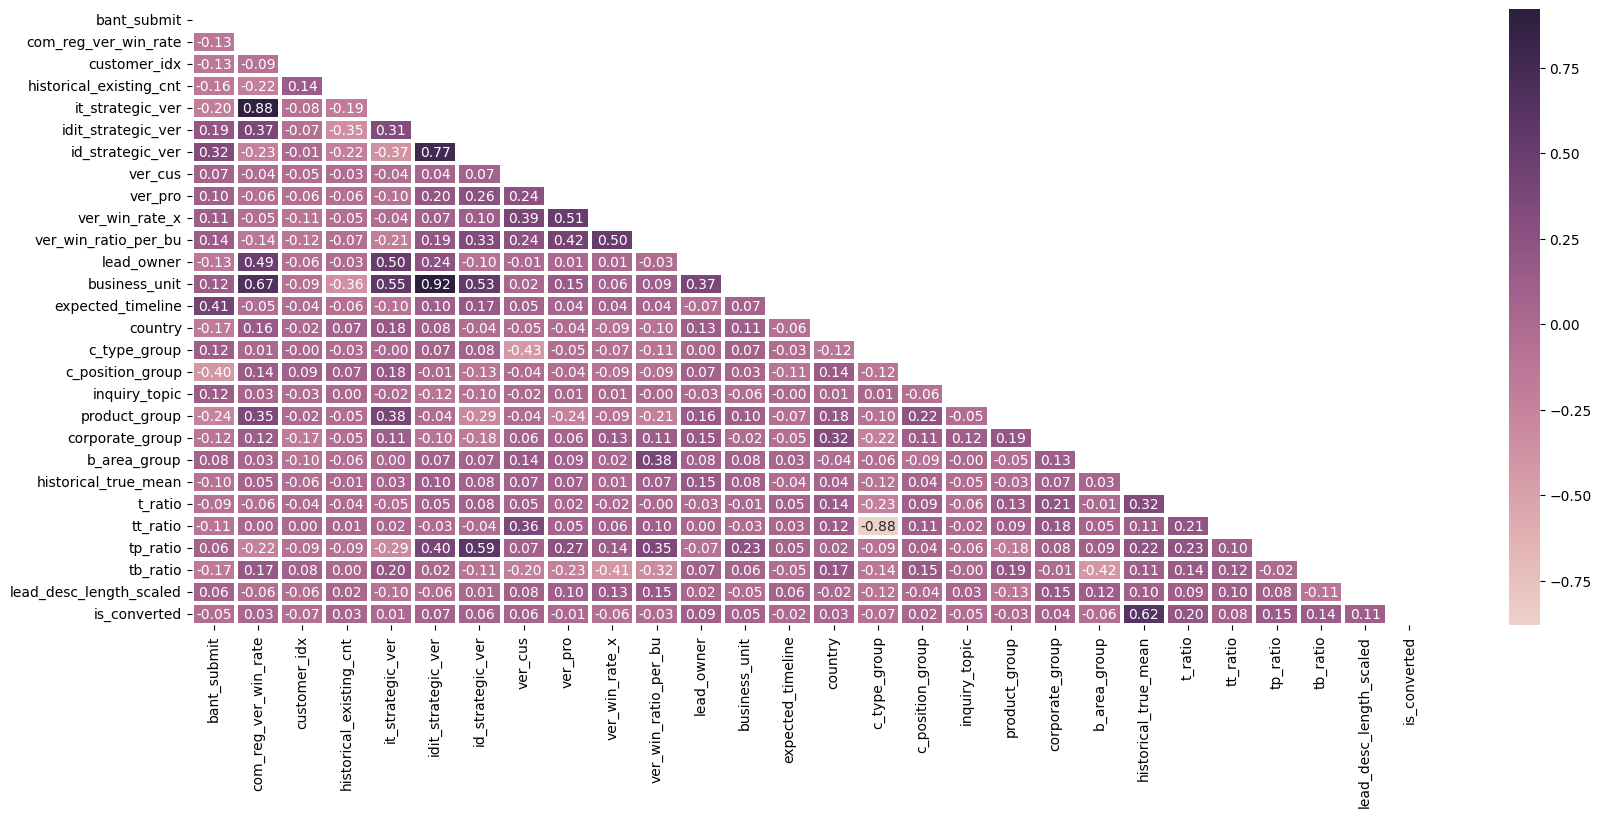

In [462]:
df_matrix = df_train[train_col].copy()

df_corr = df_matrix.corr()

plt.figure(figsize=(20, 8))

mask=np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df_corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True),
            linewidths=1.5, linecolor='White',
            fmt=".2f", mask=mask)

## 3. 모델 학습

In [463]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [464]:
df_train['is_converted'].value_counts()

False    39908
True      4463
Name: is_converted, dtype: int64

In [465]:
y_val.value_counts()

False    7982
True      893
Name: is_converted, dtype: int64

## XGBClassifier

In [466]:
import xgboost as xgb

model = xgb.XGBClassifier(#objective='binary:logistic',
                          learning_rate=0.1,
                          max_depth=10,
                          min_child_weight=30,
                          gamma=10,
                          scale_pos_weight=10,
                          colsample_bytree=0.5,
                          reg_alpha=5,
                          n_estimator=200,
                          random_state=42)
model.fit(x_train.fillna(0), y_train,
          early_stopping_rounds=50, eval_set=[(x_val, y_val)])

pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

[0]	validation_0-logloss:0.66888
[1]	validation_0-logloss:0.61293
[2]	validation_0-logloss:0.55255
[3]	validation_0-logloss:0.51228
[4]	validation_0-logloss:0.48470
[5]	validation_0-logloss:0.44435
[6]	validation_0-logloss:0.42922
[7]	validation_0-logloss:0.40407
[8]	validation_0-logloss:0.39026
[9]	validation_0-logloss:0.37126
[10]	validation_0-logloss:0.35652
[11]	validation_0-logloss:0.34689
[12]	validation_0-logloss:0.32472
[13]	validation_0-logloss:0.31721
[14]	validation_0-logloss:0.30588
[15]	validation_0-logloss:0.30010
[16]	validation_0-logloss:0.29132
[17]	validation_0-logloss:0.27552
[18]	validation_0-logloss:0.27119
[19]	validation_0-logloss:0.25791
[20]	validation_0-logloss:0.24684
[21]	validation_0-logloss:0.23670
[22]	validation_0-logloss:0.22790
[23]	validation_0-logloss:0.22060
[24]	validation_0-logloss:0.21361
[25]	validation_0-logloss:0.21263
[26]	validation_0-logloss:0.20560
[27]	validation_0-logloss:0.20055
[28]	validation_0-logloss:0.19472
[29]	validation_0-loglos

https://todayisbetterthanyesterday.tistory.com/56

 Weight : 변수 별 데이터를 분리하는데 쓰인 횟수 

 Cover : 해당 변수로 분리된 데이터의 수

 Gain : Feature을 사용했을 때 줄어드는 평균적인 training loss

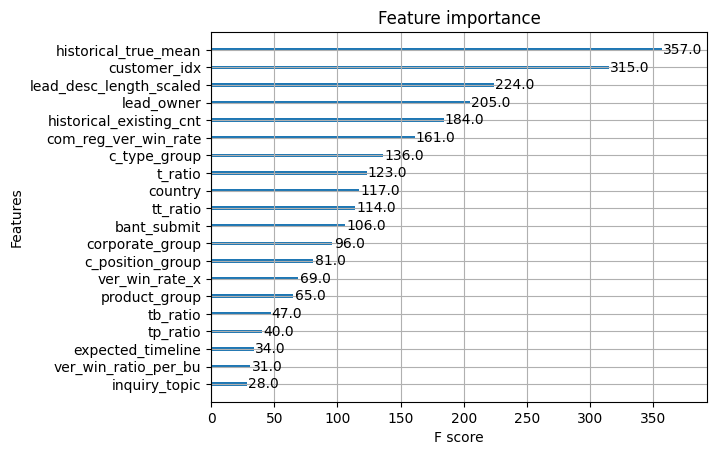

In [467]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

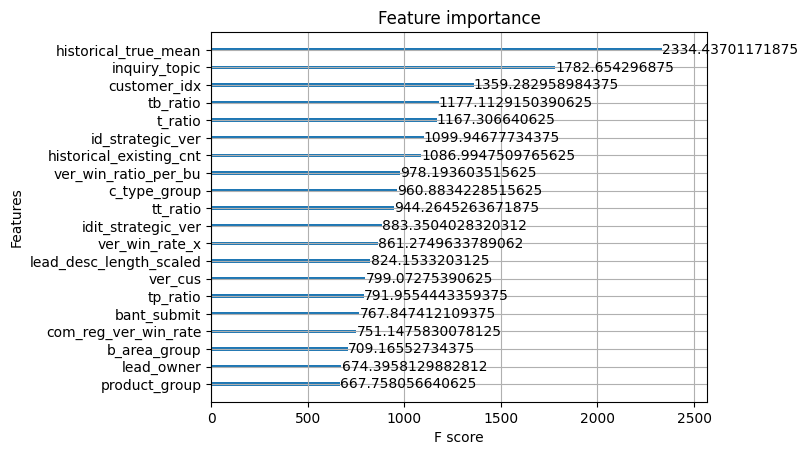

In [468]:
xgb.plot_importance(model, importance_type='cover', max_num_features=20)
plt.show()

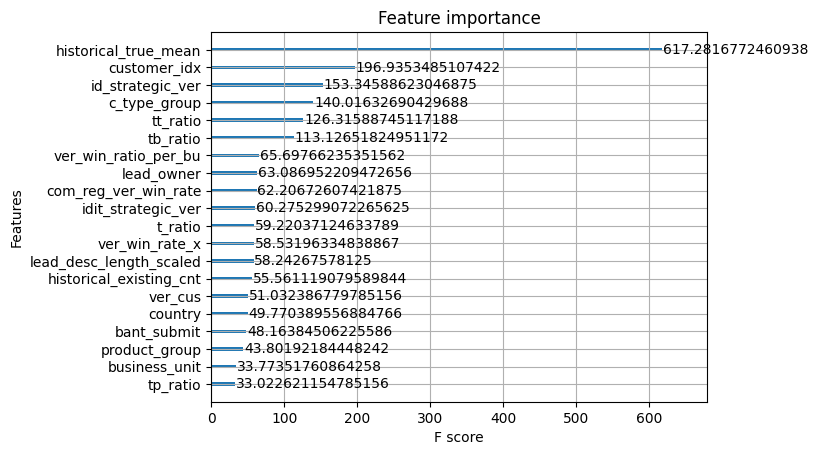

In [469]:
xgb.plot_importance(model, importance_type='gain', max_num_features=20)
plt.show()

In [470]:
import shap

explainer = shap.TreeExplainer(model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_val) # Shap Values 계산

In [471]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], x_val.iloc[1,:])

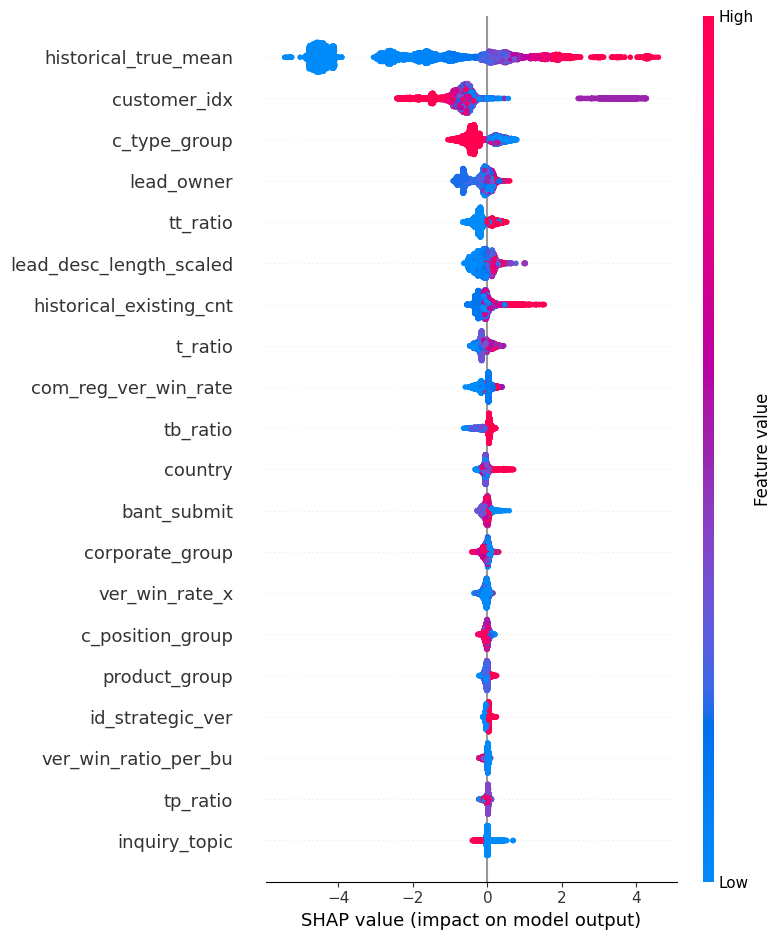

In [472]:
# summary
shap.summary_plot(shap_values, x_val)

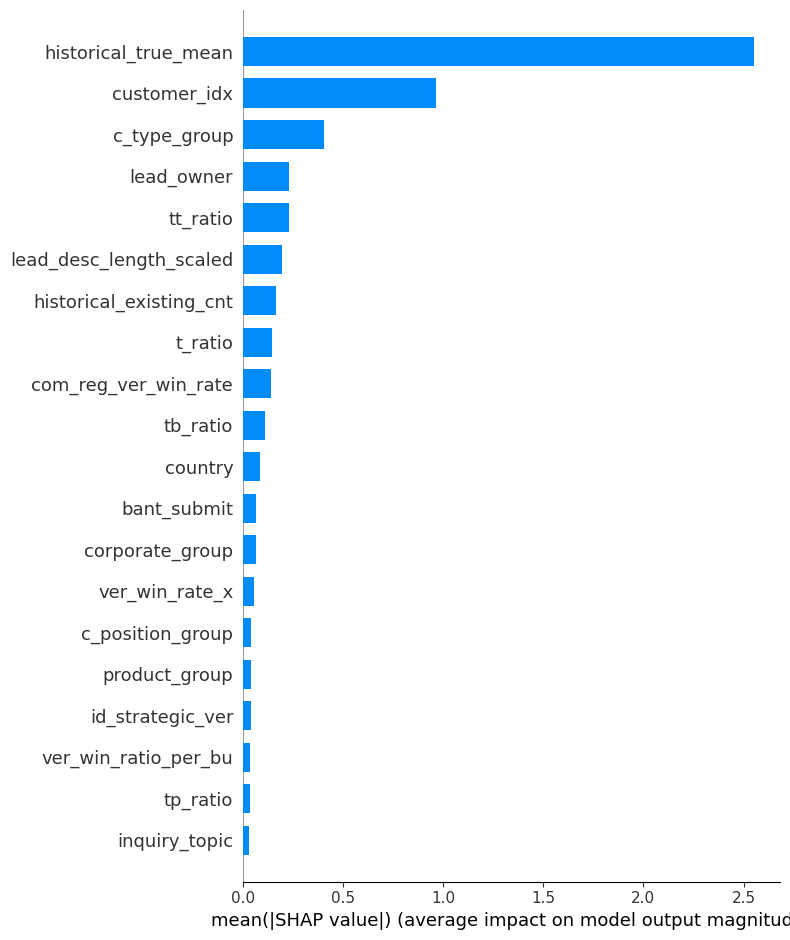

In [473]:
# 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, x_val, plot_type = "bar")

## 4. 제출하기

### 테스트 데이터 예측

In [474]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", 'id'], axis=1)

In [475]:
test_pred = model.predict(x_test[x_train.columns.tolist()].fillna(0))
sum(test_pred) # True로 예측된 개수

1689

In [476]:
pd.DataFrame(test_pred).value_counts()

0    3582
1    1689
dtype: int64

### 제출 파일 작성

In [477]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**